In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout
from keras.models import Model
import tensorflow as tf

from keras.models import load_model
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger

import os
import sys
import joblib
import glob
sys.path.append('../src/')
import vcf2onehot

In [90]:
STAR_SAMPLE = '../data/final_model/star_samples.vcf'
CURATED_FUNCTION = '../data/final_model/pcbi.1008399.s003.xlsx'
PATH_LABEL_SAVE = '../data/final_model/labels_alleles.csv'
TRAIN_PATH = '../data/final_model/train/train_data.joblib'
TEST_PATH = '../data/final_model/test/test_data.joblib'
PATH_MODEL = '../save_model/FinalModel/final_25-03-2024_02-32/model.h5'

In [91]:
def load_data(path_data: str) -> tuple:
    X = None
    y = None
    data_loaded = joblib.load(path_data)
    X = data_loaded['X']
    y = data_loaded['y']
    
    all_stars = np.array([s.split('_')[1] for s in data_loaded['sample_names']]) # lấy ra star alen: 10, 1, 2, ...
    stars, idx = np.unique(all_stars, return_index=True)
    sample_mask = np.isin(all_stars, all_stars[idx]) # Đánh dấu những star allele của idx trong all_stars
    stars_001 = np.array([s for s in data_loaded['sample_names'][sample_mask] if s.split('_')[-1] == '001']) 
    mark_001 = np.isin(data_loaded['sample_names'], stars_001)
    X_001, y_001 = X[mark_001], y[mark_001]
    
    dataset = [(X, y), (X_001, y_001)]
    
    return dataset

In [118]:
dataset_trainning = load_data(path_data=TRAIN_PATH)
dataset_evalution = load_data(path_data=TEST_PATH)

In [93]:
# def get_dataset_train_eval(determined_samples: dict) -> tuple:
#     all_stars = np.array([s.split('_')[1] for s in determined_samples['sample_names']]) # lấy ra star alen: 10, 1, 2, ...
#     stars, idx = np.unique(all_stars, return_index=True)
#     train_idx, test_idx = train_test_split(idx, stratify=determined_samples['y'][idx], test_size=24, random_state=10)
    
#     sample_mask = np.isin(all_stars, all_stars[train_idx]) # Đánh dấu những star allele của train_idx trong all_stars

#     train_stars = np.array([s for s in determined_samples['sample_names'][sample_mask] if s.split('_')[-1] == '001']) # lấy ra những allen 001 trong tập train để kiểm thử lại
#     train_mask = np.isin(determined_samples['sample_names'], train_stars) # đánh dấu những allele 001 trong determined_samples
        
#     test_stars = np.array([s for s in determined_samples['sample_names'][~sample_mask] if s.split('_')[-1] == '001']) # lấy ra những allen 001 trong tập test để kiểm thử lại
#     test_mask = np.isin(determined_samples['sample_names'], test_stars) # đánh dấu những allele 001 trong determined_samples

#     # gồm tất cả các allele + suballele sử dụng trong quá trình trainning
#     train_data = {}
#     test_data = {}
    
#     train_data['X'], train_data['y'], train_data['sample_names']= determined_samples['X'][sample_mask], determined_samples['y'][sample_mask], determined_samples['sample_names'][sample_mask]
#     test_data['X'], test_data['y'], test_data['sample_names'] = determined_samples['X'][~sample_mask], determined_samples['y'][~sample_mask], determined_samples['sample_names'][~sample_mask]
    
#     # print(train_data)
    
#     # dataset_trainning = [(train_X_all_allele, train_y_all_allele), (test_X_all_allele, test_y_all_allele)]

#     # # chỉ bao gồm các allele 001 dùng để đánh giá
#     # train_X_star, test_X_star = determined_samples['X'][train_mask], determined_samples['X'][test_mask]
#     # train_y_star, test_y_star = determined_samples['y'][train_mask], determined_samples['y'][test_mask]
#     # dataset_evalution = [(train_X_star, train_y_star), (test_X_star, test_y_star)]
    
#     # return dataset_trainning, dataset_evalution
    
    

In [94]:
# def cvtoDataset(dataset_trainning):
#     _train_ds = tf.data.Dataset.from_tensor_slices(dataset_trainning[0])
#     train_ds = _train_ds.repeat().shuffle(dataset_trainning[0][1].shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)

#     _test_ds = tf.data.Dataset.from_tensors(dataset_trainning[1])
#     test_ds = _test_ds.prefetch(buffer_size=10)
    
#     return train_ds, test_ds

In [95]:
# train_ds, test_ds = cvtoDataset(dataset_trainning)

In [97]:
def get_model_pretrained():
    model = load_model(PATH_MODEL)
    return model

In [98]:
def create_transfer_model():
    model = get_model_pretrained()
    model.pop()
    model.pop()
    model.pop()
    model.trainable = False

    layer = Dense(units=32, activation='relu', name='dense5')(model.output)
    layer = Dropout(0.3, name='dropout_4')(layer)
    layer = Dense(units=1, activation='linear', name='dense6')(layer)
    outputs = Dense(units=2, activation='sigmoid')(layer)

    transfer_model = Model(inputs=model.input, outputs=outputs, name='transfer_model')
    
    return transfer_model
    

In [99]:
now = datetime.now().strftime('%d-%m-%Y_%H-%M')

def build_and_fit(dataset):
    model = create_transfer_model()
    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.AUC()]
              )
    
    model.fit(dataset, 
              steps_per_epoch=128, 
              epochs=20, 
              verbose=True)
    
    return model
    

In [100]:
model = create_transfer_model()
model.summary()

Model: "transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1_input (InputLayer  [(None, 14868, 13)]       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2970, 70)          17360     
                                                                 
 batch_1 (BatchNormalizatio  (None, 2970, 70)          280       
 n)                                                              
                                                                 
 relu_1 (ReLU)               (None, 2970, 70)          0         
                                                                 
 maxpooling_1 (MaxPooling1D  (None, 990, 70)           0         
 )                                                               
                                                    

In [101]:
_train_ds = tf.data.Dataset.from_tensor_slices(dataset_trainning[0])
train_ds = _train_ds.repeat().shuffle(dataset_trainning[0][1].shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)

num_model = 7

for i in range(num_model):
    print(f"tfl_model_{i}.model.h5")
    model = build_and_fit(train_ds)

    model.save(f'../model/FINAL_MODEL/{now}/tfl_model_{i}.model.h5')

HT_model_0.model.h5

Epoch 1/20
128/128 [==============================] - 8s 48ms/step - loss: 0.2445 - auc: 0.6125
Epoch 2/20
128/128 [==============================] - 7s 54ms/step - loss: 0.2186 - auc: 0.6638
Epoch 3/20
128/128 [==============================] - 9s 68ms/step - loss: 0.2096 - auc: 0.7054
Epoch 4/20
128/128 [==============================] - 7s 58ms/step - loss: 0.1964 - auc: 0.7497
Epoch 5/20
128/128 [==============================] - 7s 56ms/step - loss: 0.1792 - auc: 0.7773
Epoch 6/20
128/128 [==============================] - 6s 50ms/step - loss: 0.1608 - auc: 0.7866
Epoch 7/20
128/128 [==============================] - 7s 52ms/step - loss: 0.1423 - auc: 0.8280
Epoch 8/20
128/128 [==============================] - 6s 50ms/step - loss: 0.1012 - auc: 0.9441
Epoch 9/20
128/128 [==============================] - 7s 54ms/step - loss: 0.0717 - auc: 0.9662
Epoch 10/20
128/128 [==============================] - 7s 57ms/step - loss: 0.0597 - auc: 0.9746
Epoch 11/20
128/12

c:\anaconda3\envs\ml-hus\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


HT_model_1.model.h5
Epoch 1/20
128/128 [==============================] - 10s 61ms/step - loss: 0.1838 - auc_1: 0.7361
Epoch 2/20
128/128 [==============================] - 8s 65ms/step - loss: 0.1157 - auc_1: 0.9357
Epoch 3/20
128/128 [==============================] - 7s 54ms/step - loss: 0.0766 - auc_1: 0.9646
Epoch 4/20
128/128 [==============================] - 8s 62ms/step - loss: 0.0617 - auc_1: 0.9729
Epoch 5/20
128/128 [==============================] - 7s 55ms/step - loss: 0.0557 - auc_1: 0.9745
Epoch 6/20
128/128 [==============================] - 6s 49ms/step - loss: 0.0491 - auc_1: 0.9793
Epoch 7/20
128/128 [==============================] - 6s 49ms/step - loss: 0.0472 - auc_1: 0.9779
Epoch 8/20
128/128 [==============================] - 7s 56ms/step - loss: 0.0436 - auc_1: 0.9806
Epoch 9/20
128/128 [==============================] - 8s 59ms/step - loss: 0.0421 - auc_1: 0.9799
Epoch 10/20
128/128 [==============================] - 7s 58ms/step - loss: 0.0400 - auc_1: 0.980

In [119]:
def evaluate_model():
    models = glob.glob(f'../model/FINAL_MODEL/03-06-2024_11-51/' + "*.model.h5")
    evaluates = [] 
    X_test, y_test = dataset_evalution[0]
    for m in models: 
        model = load_model(m)       
        evaluate = model.evaluate(X_test, y_test)
        evaluates.append(evaluate)
        
    print(f'Loss_test and Accuracy_test: {np.array(evaluates).mean(axis=0)}; evaluate on dataset_evalution')


In [120]:
evaluate_model()

2/2 [==============================] - 0s 36ms/step - loss: 0.0910 - auc_6: 0.9451
Loss_test and Accuracy_test: [0.10116614 0.9356765 ]; evaluate on dataset_evalution


In [42]:
class Ensemble():
    def __init__(self, X=None, dir='../model/FINAL_MODEL/03-06-2024_11-51/'):
        self.X = X
        self.raw = None
        self.predictions = None
        self.dir = dir

        self.run()

    def run(self):
        predictions = self.predict(self.X).mean(axis=0)
        pd.DataFrame(predictions, columns=['No Function', 'Normal Function']).to_csv('../data/final_model/probs.csv', index=False)
        
        # print(predictions)
        self.raw = predictions
        self.predictions = self.get_functions(predictions)

    def get_functions(self, pred):
        # cutpoint_1 = 0.4260022
        # cutpoint_2 = 0.7360413

        cutpoint_1 = 0.743              
        cutpoint_2 = 0.77       

        cut1 = np.greater(pred[:, 0], [cutpoint_1])
        cut2 = np.greater(pred[:, 1], [cutpoint_2])
        

        functions = []
        for i in range(pred.shape[0]):
            if cut1[i] == True and cut2[i] == True:
                functions.append("Normal Function")
            elif cut1[i] == True and cut2[i] == False:
                functions.append("Decreased Function")
            else:
                functions.append("No Function")

        return np.array(functions)

    def evaluate(self, y):
        labels = self.get_functions(y)
        return np.sum(labels == self.predictions) / len(y)

    def predict(self, X):
        from glob import glob
        models = glob(self.dir + "*.model.h5")
        predictions = []
        print("Predicting...")
        for m in models:
        # print(f"Predicting using {m}")
            model = tf.keras.models.load_model(m)
        
            pred = model.predict(X)
            predictions.append(pred)

        return np.array(predictions)

In [52]:
# model = load_model('../model/FINAL_MODEL/03-06-2024_11-51/tfl_model_0.model.h5')
# model.predict(test_ds)

In [43]:
def build_heatmap(pred, y, labels):
    heatmap = []
    for label in labels:
        mask = pred == label
        masked_labels = y[mask]
        heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

    return heatmap

['../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_0.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_1.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_2.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_3.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_4.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_5.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_6.model.h5']
Predicting...
1/1 [==============================] - 0s 200ms/step

Training Accuracy (only star alleles): 0.9032258064516129


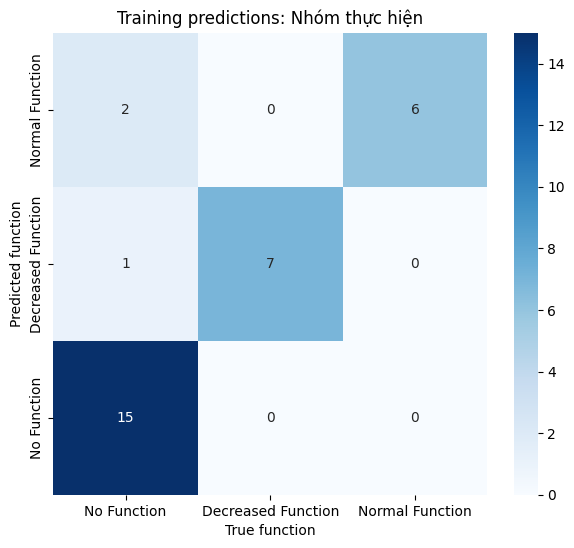

In [44]:
# Original paper attains 100% accuracy on training data star alleles
star_train_X, star_train_y = dataset_evalution[0]
# star_train_ensemble = Ensemble(star_train_X, dir='../save_model/')
star_train_ensemble = Ensemble(star_train_X)

print("\nTraining Accuracy (only star alleles):", star_train_ensemble.evaluate(star_train_y))

labels = ["Normal Function", "Decreased Function", "No Function"]

train_labels = star_train_ensemble.get_functions(star_train_y)
train_heatmap = build_heatmap(star_train_ensemble.predictions, train_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training predictions: Nhóm thực hiện")
plt.show()

In [45]:
train_labels

array(['Decreased Function', 'Normal Function', 'No Function',
       'No Function', 'No Function', 'No Function', 'Decreased Function',
       'No Function', 'No Function', 'Normal Function', 'Normal Function',
       'No Function', 'Normal Function', 'No Function', 'No Function',
       'No Function', 'Decreased Function', 'No Function',
       'Normal Function', 'Decreased Function', 'No Function',
       'Normal Function', 'Decreased Function', 'No Function',
       'No Function', 'No Function', 'No Function', 'Decreased Function',
       'No Function', 'Decreased Function', 'No Function'], dtype='<U18')

In [46]:
star_train_ensemble.predictions

array(['Decreased Function', 'Normal Function', 'No Function',
       'No Function', 'No Function', 'Decreased Function',
       'Decreased Function', 'Normal Function', 'No Function',
       'Normal Function', 'Normal Function', 'No Function',
       'Normal Function', 'No Function', 'Normal Function', 'No Function',
       'Decreased Function', 'No Function', 'Normal Function',
       'Decreased Function', 'No Function', 'Normal Function',
       'Decreased Function', 'No Function', 'No Function', 'No Function',
       'No Function', 'Decreased Function', 'No Function',
       'Decreased Function', 'No Function'], dtype='<U18')

['../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_0.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_1.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_2.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_3.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_4.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_5.model.h5', '../model/FINAL_MODEL/03-06-2024_11-51\\tfl_model_6.model.h5']
Predicting...
2/2 [==============================] - 0s 38ms/step

Test Accuracy + suballeles: 0.8448275862068966


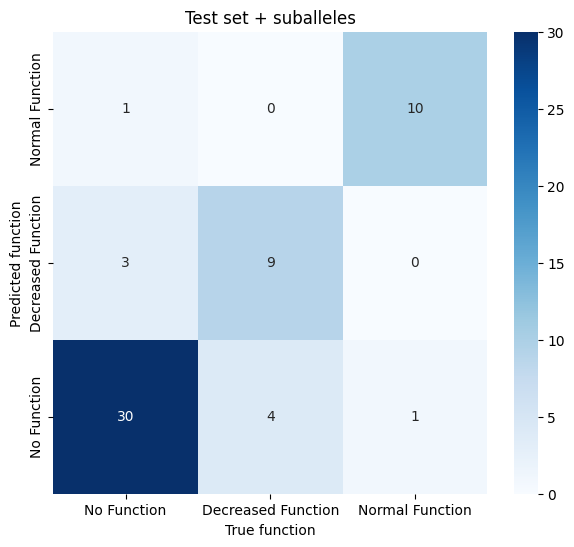

In [47]:
# All test star alleles + suballeles
test_X, test_y = dataset_trainning[1]
test_ensemble = Ensemble(test_X)
test_labels = test_ensemble.get_functions(test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy + suballeles:", test_ensemble.evaluate(test_y))

In [183]:
df = pd.read_csv('../data/final_model/probs.csv')
df['Origin_label_1'] = test_y[:, 0]
df['Origin_label_2'] = test_y[:, 1]

df['Origin_label_1'] = df['Origin_label_1'].replace({0: 'N', 1: 'Y'})
df['Origin_label_2'] = df['Origin_label_2'].replace({0: 'N', 1: 'Y'})
df.to_csv('../data/final_model/probs_test.csv', index=False)

Predicting...
1/1 [==============================] - 0s 172ms/step

Test Accuracy: 0.875


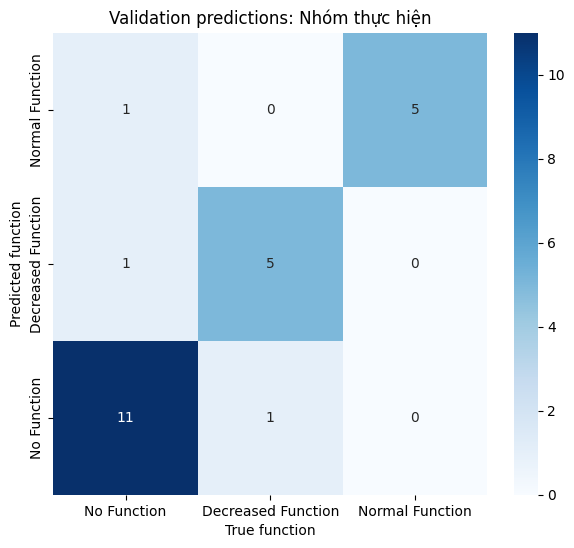

In [48]:
# All test star alleles
star_test_X, star_test_y = dataset_evalution[1]
test_ensemble = Ensemble(star_test_X)
print("\nTest Accuracy:", test_ensemble.evaluate(star_test_y))


test_labels = test_ensemble.get_functions(star_test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Validation predictions: Nhóm thực hiện")
plt.show()

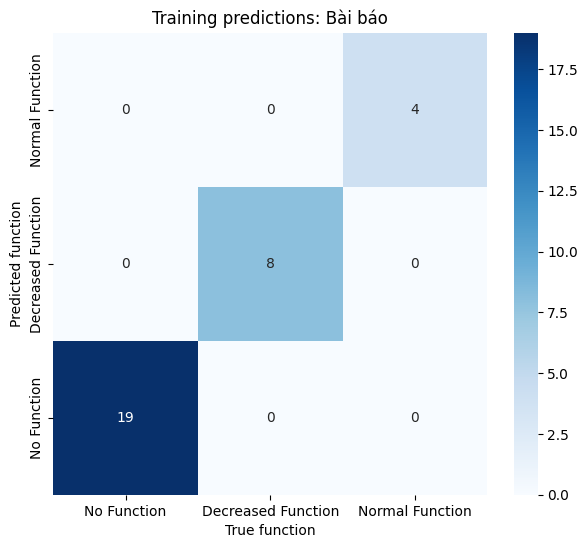

In [130]:
pred = np.array(["No Function"]*19 + ["Decreased Function"]*8 + ["Normal Function"]*4)
truth = np.array(["No Function"]*19 + ["Decreased Function"]*8 + ["Normal Function"]*4)

test_heatmap = build_heatmap(pred, truth, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training predictions: Bài báo")
plt.show()

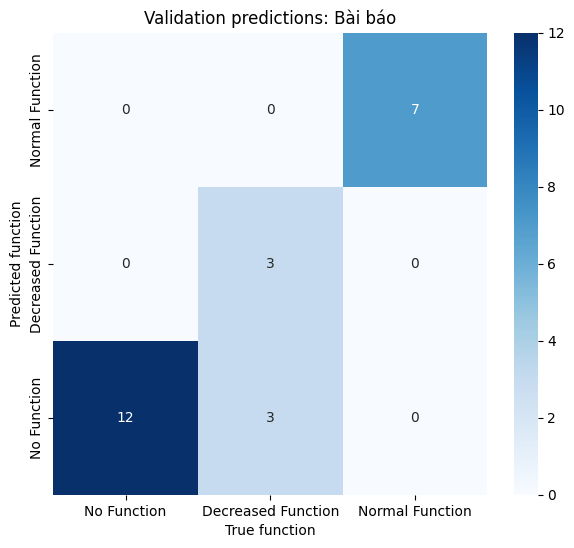

In [133]:
pred = np.array(["No Function"]*15 + ["Decreased Function"]*3 + ["Normal Function"]*7)
truth = np.array(["No Function"]*12 + ["Decreased Function"]*6 + ["Normal Function"]*7)

test_heatmap = build_heatmap(pred, truth, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Validation predictions: Bài báo")
plt.show()

In [50]:
# predict = pd.read_csv('../data/final_model/uncurated/predict.csv')
# predict

In [52]:
predict_ubncertain_labels = Ensemble(uncurated_samples['X'])

Predicting...
3/3 [==============================] - 0s 23ms/step


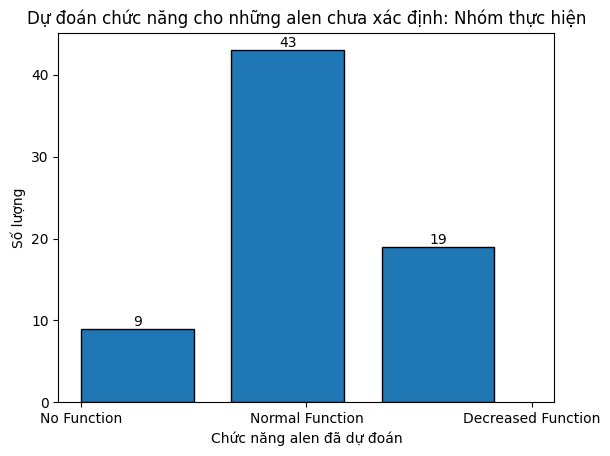

In [53]:
counts, edges, bars = plt.hist(predict_ubncertain_labels.predictions
, bins=3, edgecolor='black', width=0.5)
plt.bar_label(bars)

plt.xlabel('Chức năng alen đã dự đoán')
plt.ylabel('Số lượng')
plt.title('Dự đoán chức năng cho những alen chưa xác định: Nhóm thực hiện')
plt.show()

In [163]:
CURATED_FUNCTION = '../data/final_model/pcbi.1008399.s003.xlsx'
pred_hubble2d6 = pd.read_excel(CURATED_FUNCTION)

In [173]:
pred_hubble2d6 = pred_hubble2d6.loc[pred_hubble2d6['Curated Function'] == 'Uncurated']

In [174]:
pred_hubble2d6

,CYP2D6 Star Allele,Curated Function,Hubble Predicted Function
19,*22,Uncurated,Decreased function
20,*23,Uncurated,Normal
21,*24,Uncurated,Normal
22,*25,Uncurated,Normal
23,*26,Uncurated,Normal
...,...,...,...
122,*135,Uncurated,Normal
123,*136,Uncurated,Normal
124,*137,Uncurated,Normal
125,*138,Uncurated,No function


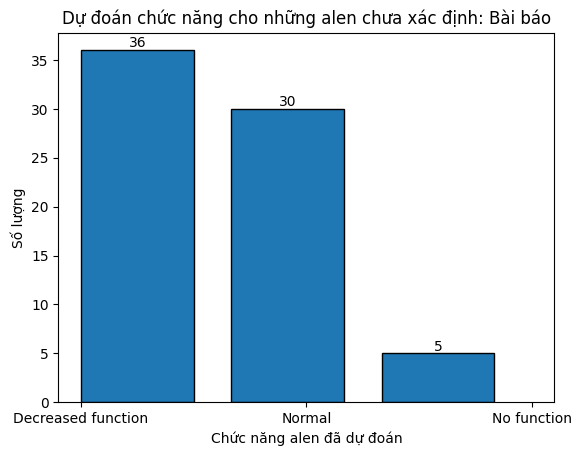

In [179]:


counts, edges, bars = plt.hist(pred_hubble2d6['Hubble Predicted Function'], bins=3, edgecolor='black', width=0.5)
plt.bar_label(bars)

plt.xlabel('Chức năng alen đã dự đoán')
plt.ylabel('Số lượng')
plt.title('Dự đoán chức năng cho những alen chưa xác định: Bài báo')
plt.show()